This Jupyter Notebook serves as a companion to the paper "[Logifold of adversarial trained models](https:// "In review")", enabling the reproduction of the machine learning experiments described therein. Our study investigates the robustness of a deep learning model trained on the CIFAR-10 dataset against various adversarial attacks, including the Fast Gradient Method (FGM) and Carlini & Wagner L2 (CWL2), leveraging the CleverHans library. 



<!-- We also discuss the current status and potential for incorporating DeepFool -->

Author: Inkee Jung and Siu-Cheong Lau, Boston University

Date: June 6, 2025

# Introduction


#TODO Here we explain a bit of theoretical perspective to the adversarial attack breifly.

Then it will contain the goal and expectation of experiments involving more on technical aspect of logifold. 




## Experiment Overview

Following paragraphs will contains precise problems : 
1. Adversarial attacks on certain parts of each model in logifold can be detected.
Having more than 1, like 100 samples, by looking at the certainty distribution, we can detect it. -> extend of agreement of committee

2. Logifold structure applied with adversarial attack shows better performance both original and adversarial samples. (Explain the way how to add/group labels)
3. Attacks can be classified using certainty threshold and the theoretic observations. (Not practical it is)

And here explain the dataset CIFAR10.

And here model types. ResNet and VGG.

And Adversarial attacks implemented by Cleverhans-lab.

References will be linked.

--- Bit more mathematical: degree of agreement, distance between model prediction on the polluted samples

## Environment and Dependencies


In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


print("NumPy Version:", np.__version__)
print("MatplotLib Version:", matplotlib.__version__)
print("Pandas Version:", pd.__version__)

import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.utils import to_categorical

## Import Cleverhans modules for adversarial attacks
# !pip install cleverhans
import cleverhans
from cleverhans.tf2 import attacks
print("CleverHans Version:", cleverhans.__version__)

## Import old version of Cleverhans which is compatible with TensorFlow version 1, and some attakcs are compatible with TensorFlow version 2.

# import cleverhans_old 
# print("Old version of Cleverhans:", cleverhans_old.__version__)
# from cleverhans_old.attacks import deep_fool

import os
import glob


2025-06-10 21:29:32.858347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
TensorFlow Version: 2.10.0
NumPy Version: 1.26.0
MatplotLib Version: 3.7.2
Pandas Version: 1.4.3
CleverHans Version: 4.0.0-edc15c6ec93c96562523dc42ae33c9e7


## CIFAR10 Preparation

x_train shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


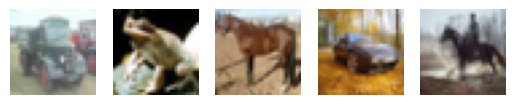

In [2]:
# Load CIFAR-10 dataset
(x, y), (x_test, y_test) = cifar10.load_data()
from sklearn.model_selection import train_test_split
x_train, x_v, y_train, y_v = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_v.shape}")
print(f"x_test shape: {x_test.shape}")

# Optional: Visualize a few images to confirm correct loading
# plt.figure(figsize=(10, 5))
for i,j in enumerate(np.random.choice(40000,5, replace=False)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[j])
    plt.axis('off')
plt.show()

## Model Training and Evaluation

Our models are based on two prominent architectures: Deep Residual Learning ([ResNet](https://ieeexplore.ieee.org/document/7780459 "Paper link, 2016 CVPR")) and Very Deep Convolutional Network ([VGG](https://arxiv.org/pdf/1409.1556 "Paper link, 2015 ICLR")). We trained four ResNet variants—ResNet20 (version 1 and 2) and ResNet56 (version 1 and 2)—as well as four VGG models: VGG11, VGG13, VGG15, and VGG19. All models were evaluated on the aforementioned testing dataset.

### Training Procedure for ResNet Models

The ResNet models are trained using a custom module based on the Deep Residual Learning architecture introduced in [He et al., 2016](https://ieeexplore.ieee.org/document/7780459 "Paper link, 2016 CVPR"). The implementation supports both version 1 and version 2 of ResNet, following the design principles used for CIFAR-10 classification.

Each ResNet model is parameterized by its depth using the formula `depth = 6n + 2`, where `n` determines the number of residual blocks per stage. In our experiments, we use:

- `n = 3` for ResNet20 (relatively shallow network)
- `n = 9` for ResNet56 (deeper network)

The `ResNet` class in the `resnet` module encapsulates the full training procedure, including:

- Model construction based on version 1 or version 2 architecture
- Training with a predefined learning rate schedule
- Checkpointing and optional data augmentation

Although the training code is commented out in this notebook, each model was trained using this setup and saved for reuse. Below, we load the pre-trained models for ResNet20 and ResNet56, both version 1 and version 2, for further evaluation.

In [3]:

## Training procedure for ResNet structure models. 
import resnet
# path = 'resnet20_cifar10.keras'
# n=3
# version = 1
# resnetmodel = resnet.ResNet(path,x_tr,y_tr,x_v,y_v,n=n,version=version)
# resnetmodel.train(save_best_only=True)

## We recall our models here.
ResNet20v1 = load_model('../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10.keras')
ResNet20v2 = load_model('../../../computer/Base_models/CIFAR10models/ResNet/n_3_v2_cifar10.keras')
ResNet56v1 = load_model('../../../computer/Base_models/CIFAR10models/ResNet/n_9_v1_cifar10.keras')
ResNet56v2 = load_model('../../../computer/Base_models/CIFAR10models/ResNet/n_9_v2_cifar10.keras')

2025-06-10 21:30:28.108520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training Procedure for VGG Models

The VGG models are constructed and trained using Keras functional API. Each model configuration follows the standard VGG architecture with varying depths, specifically VGG11, VGG13, VGG16, and VGG19, as outlined in ([Simonyan & Zisserman, 2015.](https://arxiv.org/pdf/1409.1556 "Paper link, 2015 ICLR"))

We first define a configuration dictionary specifying the layer sequences for each variant. Then, we build the models using a custom function build_vgg_functional, which constructs convolutional and pooling layers accordingly. Each model ends with global average pooling and a softmax classifier.

To train the models, we define a trainer class that wraps the entire training pipeline, including:
-	Preprocessing with optional mean subtraction
-	Model compilation with the Adam optimizer and a learning rate schedule
-	Callbacks for learning rate adjustment and model checkpointing
-	Support for optional real-time data augmentation via ImageDataGenerator

The learning rate is scheduled to decrease progressively at specific epochs (80, 120, 160, and 180), as commonly done for CIFAR-10 training.

Below, we show the training pipeline applied to the CIFAR-10 dataset. Each model was trained and saved individually following this procedure. In this notebook, we load the pre-trained models directly for evaluation and further experiments.

In [6]:
## Training procedure for VGG structure models.
from keras import layers, Model, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import math

## VGG configurations
config = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

## Function constructing VGG models
def build_vgg_functional(vgg_name, num_classes):
    inputs = Input(shape=(32, 32, 3))
    x = inputs
    for l in config[vgg_name]:
        if l == 'M':
            x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
        else:
            x = layers.Conv2D(l, kernel_size=3, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)

    x = layers.AveragePooling2D(pool_size=1, strides=1)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

## Custom learning rate schedule
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    return lr

## Define a trainning class.
## This trainer is originated from the ResNet module above.
class trainer():
    def __init__(self, path, x_tr, y_tr, x_v, y_v, model_name,num_classes,subtract_pixel_mean = True,):
        assert len(y_tr.shape)==2
        assert len(y_v.shape)==2
        assert len(x_tr.shape)==4
        assert len(x_v.shape)==4
        
        self.path = path #"path_of_folder/" for saving and loading
        
        # if subtract pixel mean is enabled
        if subtract_pixel_mean:
            x_train_mean = np.mean(x_tr, axis=0)
            x_tr -= x_train_mean
            x_v -= x_train_mean          
        
        self.x_tr = x_tr
        self.y_tr = y_tr
        self.x_v = x_v
        self.y_v = y_v
        self.subtract_pixel_mean = subtract_pixel_mean
        self.model = build_vgg_functional(model_name, num_classes=num_classes)
        self.model.save(path)
    def train(self, batch_size = 32, epochs = 200, 
              data_augmentation = True, optimizer=None,loss='categorical_crossentropy', 
              save_best_only=False,save_weights_only=False):
              
        if optimizer is None:
              optimizer=Adam(learning_rate=lr_schedule(0))
              
        self.optimizer = optimizer
        self.model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=['acc'])
              
        # prepare callbacks for model saving and for learning rate adjustment.
        checkpoint = ModelCheckpoint(filepath=self.path,
                                     monitor='val_acc',
                                     verbose=1,
                                     save_best_only=save_best_only, save_weights_only=save_weights_only)

        lr_scheduler = LearningRateScheduler(lr_schedule)

        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                       cooldown=0,
                                       patience=5,
                                       min_lr=0.5e-6)

        callbacks = [checkpoint, lr_reducer, lr_scheduler]

        # run training, with or without data augmentation.
        if not data_augmentation:
            print('Not using data augmentation.')
            self.model.fit(self.x_tr, self.y_tr,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(self.x_v, self.y_v),
                      shuffle=True,
                      callbacks=callbacks)
        else:
            print('Using real-time data augmentation.')
            # this will do preprocessing and realtime data augmentation:
            datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False)

            # compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            datagen.fit(self.x_tr)

            steps_per_epoch =  math.ceil(len(self.x_tr) / batch_size)
            # fit the model on the batches generated by datagen.flow().
            self.model.fit(x=datagen.flow(self.x_tr, self.y_tr, batch_size=batch_size),
                      verbose=0,
                      epochs=epochs,
                      validation_data=(self.x_v, self.y_v),
                      steps_per_epoch=steps_per_epoch,
                      callbacks=callbacks)
        return 


In [4]:
## Actual training procedure here.
## And we recall models what we have already trained according to this procedure.

# vgg = trainer('models/CIFAR10_vgg11.keras',x_train,y_train,x_v,y_v,'vgg11',10)
# vgg.model.summary()
# vgg.train(save_best_only=True,save_weights_only = False)
vgg11 = load_model('../../../computer/Base_models/CIFAR10models/VGG/CIFAR10_vgg11.keras')

# vgg = trainer('models/CIFAR10_vgg13.keras',x_train,y_train,x_v,y_v,'vgg13',10)
# vgg.model.summary()
# vgg.train(save_best_only=True,save_weights_only = False)
vgg13 = load_model('../../../computer/Base_models/CIFAR10models/VGG/CIFAR10_vgg13.keras')

# vgg = trainer('models/CIFAR10_vgg16.keras',x_train,y_train,x_val,y_val,'vgg16',10)
# vgg.model.summary()
# vgg.train(save_best_only=True,save_weights_only = False)
vgg16 = load_model('../../../computer/Base_models/CIFAR10models/VGG/CIFAR10_vgg16.keras')

# vgg = trainer('models/CIFAR10_vgg19.keras',x_train,y_train,x_val,y_val,'vgg19',10)
# vgg.model.summary()
# vgg.train(save_best_only=True,save_weights_only = False)
vgg19 = load_model('../../../computer/Base_models/CIFAR10models/VGG/CIFAR10_vgg19.keras')

### Evaluation

In [8]:
model_dict = {
    'VGG11': vgg11,
    'VGG13': vgg13,
    'VGG16': vgg16,
    'VGG19': vgg19,
    'ResNet20v1': ResNet20v1,
    'ResNet20v2': ResNet20v2,
    'ResNet56v1': ResNet56v1,
    'ResNet56v2': ResNet56v2
}

# Dictionary to store evaluation results
results = {}

# Evaluate each model
testing_y = to_categorical(y_test,10)
for name, model in model_dict.items():
    loss, acc = model.evaluate(x_test, testing_y, verbose=0)
    results[name] = {'loss': loss, 'accuracy': acc}

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T.sort_values('accuracy', ascending=False)
display(results_df)

,loss,accuracy
ResNet56v1,0.622501,0.8785
VGG13,0.888626,0.8661
VGG16,0.874750,0.8600
VGG19,1.098816,0.8577
ResNet20v1,0.889513,0.8248
ResNet56v2,0.792480,0.8218
ResNet20v2,0.791303,0.8208
VGG11,1.356550,0.7871


## Generating Adversarial Examples on CIFAR10 dataset

We generate adversarial examples using several well-known adversarial attack methods from the `cleverhans` library. For visualization, we show the first 10 adversarial images and compare them to their original versions. The predicted labels are shown above each image.

---

Example images are generaged by `ResNet56v1`

In [28]:
from cleverhans.tf2.attacks import basic_iterative_method as bim #pgd with rand_minmax=0.3 and sanity_checks=True as default

from cleverhans.tf2.attacks import madry_et_al as madry # pgd with rand_minmax=0.3, rand_init=True, and sanity_checks=True as default.
from cleverhans.tf2.attacks import momentum_iterative_method as mim
from cleverhans.tf2.attacks import spsa

class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def show_images(images, preds=None, title='Images', true_labels=None):
    """Display 5 images in a row with optional predicted and true labels."""
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        pred = np.argmax(preds[i]) if preds is not None else None
        true = np.argmax(true_labels[i]) if true_labels is not None else None

        label_str = ""
        if true_labels is not None:
            label_str += f"T:{class_names[true]}"
        if preds is not None:
            label_str += f"\nP:{class_names[pred]}"
        ax.set_title(label_str)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
model = ResNet56v1
training_y = to_categorical(y_train,10)

### Fast Gradient Method (FGM)

The [Fast Gradient Method](https://arxiv.org/pdf/1412.6572 "Paper link, 2015 ICLR") (FGM or FGSM with one iteration) perturbs the input in the direction of the gradient of the loss function with respect to the input.

FGM is a one-step attack. It’s fast but often detectable.

1/1 [==============================] - 1s 536ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


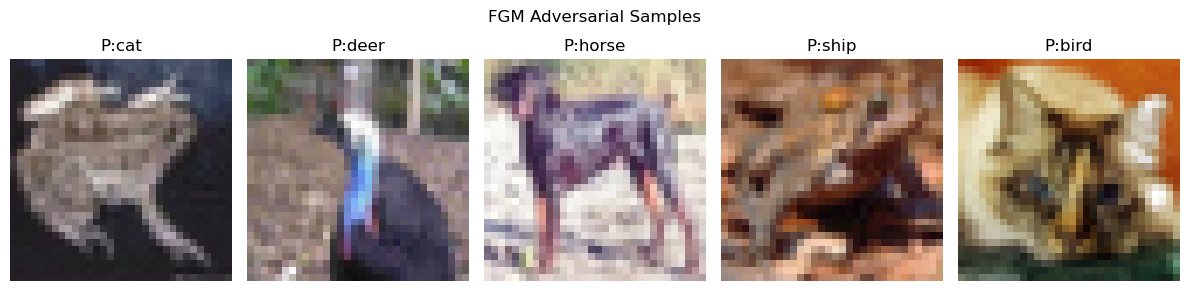

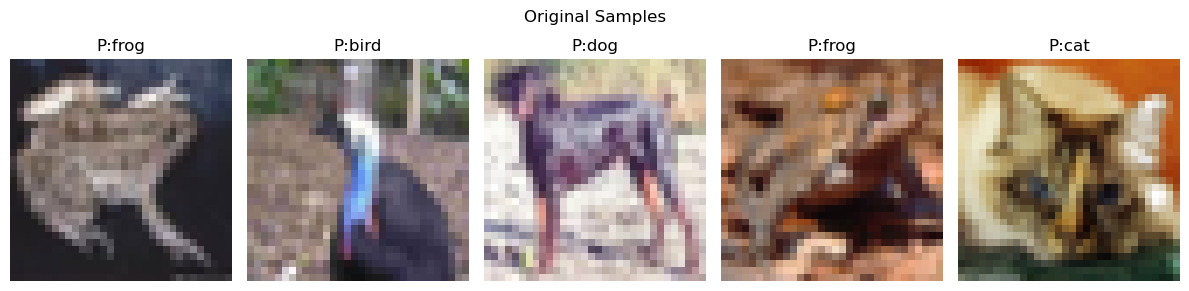

In [29]:
from cleverhans.tf2.attacks import fast_gradient_method as fgm # 1-step gradient method.
adv = fgm.fast_gradient_method(model, x_train[:5], eps=0.3, norm=2)
adv_y = model.predict(adv)
show_images(adv, adv_y, title="FGM Adversarial Samples")
show_images(x_train[:5], training_y[:5], title="Original Samples")

### Projective Gradient Descent (PGD)

[PGD](https://arxiv.org/pdf/1607.02533 "Paper link, 2017 ICLR") is an iterative extension of FGM, applying multiple gradient steps and projecting back into the $\epsilon$-ball to stay within valid perturbation bounds. It is a strong white-box attack. This includes:
- BIM (Basic Iterative Method): PGD with rand_init disabled.
- Madry’s Method: PGD with random starts.


1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


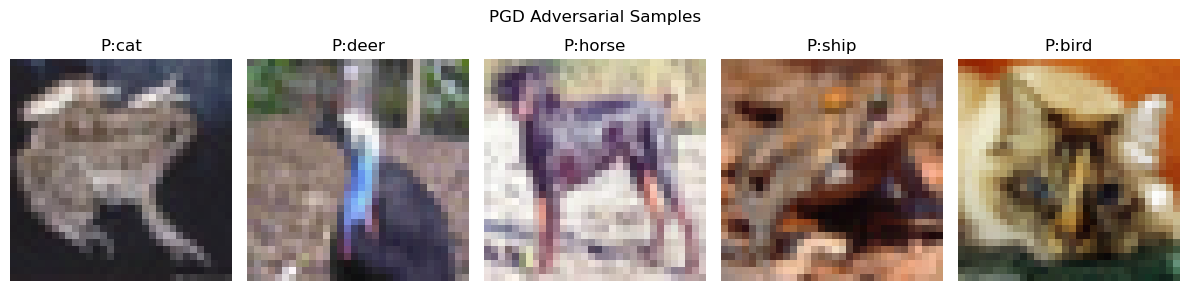

In [30]:
from cleverhans.tf2.attacks import projected_gradient_descent as pgd #iterative version of fgm

adv = pgd.projected_gradient_descent(model, x_train[:5], eps=0.3, eps_iter=0.01, nb_iter=40, norm=2)
adv_y = model.predict(adv)

show_images(adv, adv_y, title="PGD Adversarial Samples")

### Generating samples - PGD

Due to memory constraints, adversarial images from the CIFAR-10 test set are generated in batches of 2,500 samples. Here, we load the previously generated adversarial examples.

In [124]:
# # PGD configuration
# eps = 216 / 255  # Max perturbation
# eps_iters = [9/255, 27/255, 48/255, 96/255]  # Step sizes
# nb_iter = 8
# norm = 2
# batch_size = 2500
# num_batches = 4

# GENmodel = ResNet56v1

# # Compute target labels
# logits = GENmodel(x_test, training=False)
# top2 = tf.math.top_k(logits, k=2)[1]
# second_likely = top2[:, 1].numpy()
# least_likely = tf.argmin(logits, axis=-1).numpy()

# # Choose attack type: "untargeted", "targeted_second", or "targeted_least"
# attack_type = "targeted_least"
# def get_target_labels(start, end):
#     if attack_type == "untargeted":
#         return y_test.reshape(-1)[start:end]  # untargeted attack
#     elif attack_type == "targeted_second":
#         return second_likely[start:end]
#     elif attack_type == "targeted_least":
#         return least_likely[start:end]

# print(f"Generating {attack_type} PGD adversarial examples...")
# for eps_iter in eps_iters:
#     advs_x, advs_y = [], []
#     label = np.round(eps_iter, 3)
#     print(f"Epsilon step = {label}")
    
#     for i in range(num_batches):
#         start, end = i * batch_size, (i + 1) * batch_size
#         print(f"{start} - {end}", end=' ')
        
#         x_batch = x_test[start:end]
        
#         adv = pgd.projected_gradient_descent(GENmodel, x_batch, eps, eps_iter,
#                                              nb_iter, norm, y=get_target_labels(start,end), 
#                                              targeted = False if attack_type == 'untargeted' else True)
        
#         advs_x.append(adv)
    
#     advs_x = np.concatenate(advs_x, axis=0)
#     np.save(f'adversarial_examples/pgd_{label}_x_{attack_type}.npy', advs_x)
#     print(f'Saved PGD {attack_type} samples for ε={label}\n')
PGD_ResNet56v1_test_untargeted = np.load('../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_untarget.npy')
PGD_ResNet56v1_test_targeted_to_2nd = np.load('../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_target_to_second.npy')
PGD_ResNet56v1_test_targeted_to_least = np.load('../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_target_to_ll.npy')

PGD_ResNet56v1_train_untargeted = np.load('../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_untarget.npy')
PGD_ResNet56v1_val_untargeted = np.load('../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_val_untarget.npy')


The following code loads pre-generated adversarial examples by selecting the attack type and generating models.

In [25]:
# import os, glob
# folder = '../../../computer/Adversarial_Examples/by_VGG/'
# attack_type = 'untarget' # untarget or target_to_ll
# modelname = 'vgg11' # vgg11 or vgg13 or vgg16 or vgg19
# pattern = os.path.join(folder, f'*{attack_type}_by_{modelname}*.npy')
# file_list = sorted(glob.glob(pattern))

# loaded_samples= {os.path.basename(f): np.load(f) for f in file_list}

['../../../computer/Adversarial_Examples/by_VGG/pgd_0.376_x_test_untarget_by_vgg16.npy',
 '../../../computer/Adversarial_Examples/by_VGG/pgd_0.376_x_test_untarget_by_vgg16_0.npy',
 '../../../computer/Adversarial_Examples/by_VGG/pgd_0.376_x_test_untarget_by_vgg16_1.npy',
 '../../../computer/Adversarial_Examples/by_VGG/pgd_0.376_x_test_untarget_by_vgg16_2.npy']

In [29]:
# folder = '../../../computer/Adversarial_Examples/by_ResNet/'
# attack_type = 'untarget' # untarget or target_to_ll
# n = 3 # 3 or 9
# v = 1 # 1 or 2
# pattern = os.path.join(folder, f'*{attack_type}*_by_n_{n}_v{v}*.npy')
# file_list = sorted(glob.glob(pattern))
# loaded_samples= {os.path.basename(f): np.load(f) for f in file_list}

['../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10.keras.npy',
 '../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10_1.keras.npy',
 '../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10_2.keras.npy',
 '../../../computer/Adversarial_Examples/by_ResNet/pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10_3.keras.npy']

### Carlini and Wagner in L2 metric

[CWL2](https://arxiv.org/pdf/1608.04644 "Paper link, 2017 SP") is an optimization-based attack using a specially designed loss function to minimize L2 distortion. It is powerful but computationally expensive.

1/1 [==============================] - 0s 23ms/step


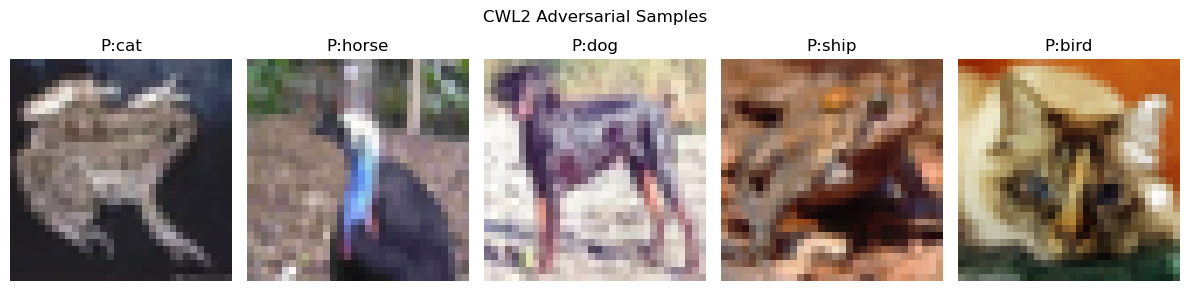

In [37]:
from cleverhans.tf2.attacks import carlini_wagner_l2 as cw # slow and small perturbation
show_adv_x = []
show_adv_y = []
for i in range(5):
        
    adv = cw.carlini_wagner_l2(model, x_train[i:i+1])
    adv_y = model.predict(adv)
    show_adv_x.append(adv[0])
    show_adv_y.append(adv_y[0])
adv = np.array(show_adv_x)
adv_y = np.array(show_adv_y)
show_images(adv, adv_y, title="CWL2 Adversarial Samples")

### Generating samples - CWL2

Due to memory constraints, we generate adversarial images from the CIFAR-10 test set one at a time, rather than in batches. Here we load previously generated adversarial samples.

In [125]:
# # ---
# # CWL2 Adversarial Example Generation on CIFAR-10 Validation Set
# # ---
# import os
# # Load pretrained model (ResNet56, ~0.85M parameters)

# GENmodel = ResNet56v1


# # Compute target labels
# logits = GENmodel(x_test, training=False)
# top2 = tf.math.top_k(logits, k=2)[1]
# second_likely = top2[:, 1].numpy()
# least_likely = tf.argmin(logits, axis=-1).numpy()

# # Choose attack type: "untargeted", "targeted_second", or "targeted_least"
# attack_type = "targeted_least"
# def get_target_labels(index):
#     if attack_type == "untargeted":
#         return None  # untargeted attack
#     elif attack_type == "targeted_second":
#         return second_likely[index:index+1]
#     elif attack_type == "targeted_least":
#         return least_likely[index:index+1]


# # Generate and save adversarial examples in batches
# output_dir = 'adversarial_examples'
# os.makedirs(output_dir, exist_ok=True)

# start_idx, end_idx = 0, 10000
# batch_size = 1000
# buffer = []

# for idx in range(start_idx, end_idx):
#     y_target = get_target_labels(index)
#     adv_cwl2 = cw.CarliniWagnerL2(GENmodel, max_iterations=100, binary_search_steps=5,
#                                   targeted = (y_target is not None), 
#                                   y = y_target)

#     adv_example = adv_cwl2.attack(x_test[idx:idx+1])
#     buffer.append(adv_example)
#     # Save every 1000 samples
#     if (idx + 1) % batch_size == 0 or idx == end_idx - 1:
#         k = (idx - start_idx + 1) // batch_size
#         adv_x = np.concatenate(buffer, axis=0)
#         buffer = []

#         x_fname = f'cwl2_x_test_untargeted_{start_idx + k*batch_size - batch_size}to{start_idx + k*batch_size - 1}.npy'
#         
#         x_path = os.path.join(output_dir, x_fname)
#         
#         np.save(x_path, adv_x)
#         print(f"[{idx+1}] Saved adversarial examples to: {x_path}")

CWL2_adv_test_untargetd = np.load('../../../computer/Adversarial_Examples/by_ResNet/cwl2_x_test_untargeted.npy')
CWL2_adv_test_targeted_to_2nd = np.load('../../../computer/Adversarial_Examples/by_ResNet/cwl2_x_test_targeted_to_2nd.npy')
CWL2_adv_test_targeted_to_least = np.load('../../../computer/Adversarial_Examples/by_ResNet/cwl2_x_test_targeted_to_ll.npy')

The Momentum Iterative Method ([MIM](https://openaccess.thecvf.com/content_cvpr_2018/papers/Dong_Boosting_Adversarial_Attacks_CVPR_2018_paper.pdf "Paper link, CVPR 2018")) improves PGD by incorporating a momentum term, which helps stabilize the update direction across iterations and improves the transferability of adversarial examples across different models. The Simultaneous Perturbation Stochastic Approximation ([SPSA](https://proceedings.mlr.press/v80/uesato18a.html "Paper link, PMLR 2018")) is a gradient-free attack that estimates gradients using two-sided finite differences. This makes it particularly suitable for **black-box** settings and models with non-differentiable components. In this work, however, we focus on generating adversarial examples using only PGD and CWL2 attacks.

# Experiment 1: Adversarial attacks on Certain Part

Following experiment shows that adversarially perturbed image of confident parts of each model in logifold provides a degree of agreement, which can be used for detecting whether it is adversarial attack.

In [ ]:
## Define sigmoid function
import math
def sigmoid(x, scale = 1):
    return 1/(1+math.exp(-scale*x))

In [66]:
certainty_threshold = sigmoid(10) 
print('Certainty threshold :', certainty_threshold)

Certainty threshold : 0.9999546021312976


In [67]:
prediction = ResNet56v1.predict(x_test)
prediction_on_adv = ResNet56v1.predict(PGD_ResNet56v1_test_untargeted)
mask = np.max(prediction, axis=-1)>certainty_threshold


313/313 [==============================] - 26s 82ms/step


In [68]:
print('accuracy of ResNet56v1:',np.sum(np.argmax(prediction,axis=-1) == y_test.reshape(-1))/len(x_test))
print('accuracy of ResNet56v1 to the adversarial attack globally:',np.sum(np.argmax(prediction_on_adv,axis=-1) == y_test.reshape(-1))/len(x_test))

print('accuracy on the certain part:', np.sum(np.argmax(prediction[mask],axis=-1) == y_test[mask].reshape(-1))/np.sum(mask))
print('the size of certain part:', np.sum(mask))
print('accuracy of ResNet56v1 to the adversarial attack on certain part:', np.sum(np.argmax(prediction_on_adv[mask],axis=-1) == y_test[mask].reshape(-1))/np.sum(mask))

accuracy of ResNet56v1: 0.8785
accuracy of ResNet56v1 to the adversarial attack globally: 0.0097
accuracy on the certain part: 0.9971802102025121
the size of certain part: 3901
accuracy of ResNet56v1 to the adversarial attack on certain part: 0.024865419123301716


In [70]:
folder = '../../../computer/Base_models/CIFAR10models/ResNet/'
pattern = os.path.join(folder, '*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models= {os.path.basename(f): load_model(f) for f in file_list}

In [237]:
file_list

['../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_1.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_2.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_3.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_4.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_5.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_6.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v1_cifar10_7.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v2_cifar10.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v2_cifar10_1.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v2_cifar10_2.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_3_v2_cifar10_3.keras',
 '../../../computer/Base_models/CIFAR10models/ResNet/n_9_v1_cifar10.

In [238]:
sigmoid(10)

0.9999546021312976

In [87]:
predictions= {os.path.basename(f): loaded_models[os.path.basename(f)].predict(x_test,verbose=0) for f in file_list}
certain_masks = {os.path.basename(f): np.max(predictions[os.path.basename(f)],axis=-1)>sigmoid(10) for f in file_list}


313/313 [==============================] - 60s 190ms/step


In [89]:
reports = {}
for f in file_list:
    f = os.path.basename(f)
    prediction = predictions[f]
    mask = certain_masks[f]
    global_acc = np.sum(np.argmax(prediction,axis=-1) == y_test.reshape(-1))/len(x_test)
    accuracy_on_certain = np.sum(np.argmax(prediction[mask],axis=-1) == y_test[mask].reshape(-1))/np.sum(mask)
    size_of_certain = np.sum(mask)
    depth = '56' if 'n_3' in f else '20'
    version = 'v1' if 'v1' in f else 'v2'
    suffix = f.split('.keras')[0][-1]
    name = f'ResNet{depth}{version}_{suffix}'
    reports[name] = {'global_acc': global_acc, 'acc_on_certain': accuracy_on_certain, 'size_of_certain':size_of_certain}
    
import pandas as pd
reports_df = pd.DataFrame(reports).T
display(reports_df)


,global_acc,acc_on_certain,size_of_certain
ResNet56v1_0,0.8248,0.993137,3060.0
ResNet56v1_1,0.8520,0.996769,3405.0
ResNet56v1_2,0.8534,0.997637,3386.0
ResNet56v1_3,0.8592,0.998719,3123.0
ResNet56v1_4,0.8485,0.999527,2116.0
ResNet56v1_5,0.8600,0.996759,3394.0
ResNet56v1_6,0.8439,0.996360,3022.0
ResNet56v1_7,0.8251,0.995483,2878.0
ResNet56v2_0,0.8208,0.997230,1805.0
ResNet56v2_1,0.8017,0.993967,1989.0


In [239]:
np.sum(intersection_of_masks)

397

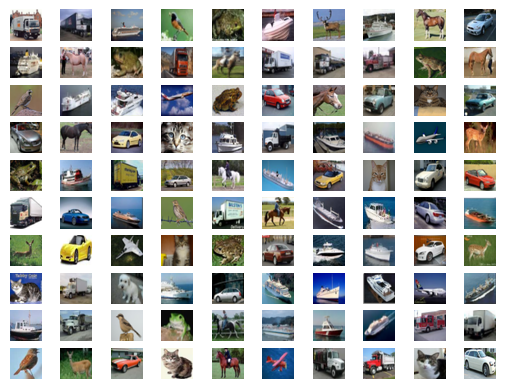

In [105]:
## Show several instances of the certain part

intersection_of_masks =  np.logical_and.reduce(np.array(list(certain_masks.values())))

for i,j in enumerate(range(100)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_test[intersection_of_masks][j])
    plt.axis('off')
plt.show()

In [243]:
import collections
reports = collections.defaultdict(dict)
x_test_certain_part = x_test[intersection_of_masks]
x_test_pgd_certain_part = PGD_ResNet56v1_test_untargeted[intersection_of_masks]
x_test_cwl2_certain_part = CWL2_adv_test_untargetd[intersection_of_masks]
for index in [6]:
    for f in file_list:
        f = os.path.basename(f)
        model = loaded_models[f]
        p1 = model.predict(x_test_certain_part[index:index+1], verbose = 0)
        p2 = model.predict(x_test_pgd_certain_part[index:index+1], verbose = 0)
        p3 = model.predict(x_test_cwl2_certain_part[index:index+1], verbose = 0)
        depth = '56' if 'n_3' in f else '20'
        version = 'v1' if 'v1' in f else 'v2'
        suffix = f.split('.keras')[0][-1]
        name = f'ResNet{depth}{version}_{suffix}'
        reports[name].update({
            (f'X_{index}', 'p'): round(float(np.max(p1)),3),
            (f'X_{index}', 'cl'): int(np.argmax(p1)),
            (f'X_{index}(PGD)', 'p'): round(float(np.max(p2)),3),
            (f'X_{index}(PGD)', 'cl'): int(np.argmax(p2)),
            (f'X_{index}(CWL2)', 'p'): round(float(np.max(p3)),3),
            (f'X_{index}(CWL2)', 'cl'): int(np.argmax(p3)),
        })

reports_df = pd.DataFrame(reports).T
display(reports_df)

X_6      X_6(PGD)      X_6(CWL2)     
                p   cl        p   cl         p   cl
ResNet56v1_0  1.0  4.0    0.638  4.0     1.000  4.0
ResNet56v1_1  1.0  4.0    0.999  7.0     1.000  4.0
ResNet56v1_2  1.0  4.0    0.997  7.0     1.000  4.0
ResNet56v1_3  1.0  4.0    0.721  4.0     1.000  4.0
ResNet56v1_4  1.0  4.0    0.584  4.0     0.999  4.0
ResNet56v1_5  1.0  4.0    0.995  7.0     1.000  4.0
ResNet56v1_6  1.0  4.0    0.973  4.0     1.000  4.0
ResNet56v1_7  1.0  4.0    0.505  7.0     1.000  4.0
ResNet56v2_0  1.0  4.0    0.460  4.0     1.000  4.0
ResNet56v2_1  1.0  4.0    0.988  4.0     1.000  4.0
ResNet56v2_2  1.0  4.0    0.586  4.0     1.000  4.0
ResNet56v2_3  1.0  4.0    0.962  4.0     1.000  4.0
ResNet20v1_0  1.0  4.0    1.000  7.0     0.951  7.0
ResNet20v1_1  1.0  4.0    0.965  7.0     1.000  4.0
ResNet20v1_2  1.0  4.0    0.999  7.0     1.000  4.0
ResNet20v1_3  1.0  4.0    0.804  7.0     1.000  4.0
ResNet20v2_0  1.0  4.0    0.960  7.0     1.000  4.0
ResNet20v2_1  1.0  4.0    0.520  4.0     1.000  4.0
ResNet20v2_2  1.0  4.0    0.994  4.0     1.000  4.0
ResNet20v2_3  1.0  4.0    0.970  7.0     1.000  4.0

In [240]:
counts

8.0    11
0.0     5
3.0     4
Name: (X_2(PGD), cl), dtype: int64

In [241]:
counts = reports_df['X_2(PGD)', 'cl'].value_counts()
from scipy.stats import entropy
possible_categories = len(counts)  
entropy(counts, base=possible_categories)

0.9077556599985014

In [187]:
counts

8.0    11
0.0     5
3.0     4
Name: (X_2(PGD), cl), dtype: int64

$\sum p_i \log_{\text{the number of categories}} p_i$

$p_0 = 11/20, p_1 = 5/20, p_2 = 4/20, \text{the number of categories} = 3$

In [246]:
-(10/20)*math.log(10/20,10)-(10/20)*math.log(10/20,10)

0.30102999566398114

In [190]:
buffer1 = []
buffer2 = []
buffer3 = []
for f in file_list:
    f = os.path.basename(f)
    model = loaded_models[f]
    buffer1.append(model.predict(x_test_certain_part, verbose = 0))
    buffer2.append( model.predict(x_test_pgd_certain_part, verbose = 0))
    buffer3.append(model.predict(x_test_cwl2_certain_part, verbose = 0))


In [191]:
np.argmax(buffer1,axis=-1)


array([[9, 9, 8, ..., 1, 8, 5],
       [9, 9, 8, ..., 1, 8, 5],
       [9, 9, 8, ..., 1, 8, 5],
       ...,
       [9, 9, 8, ..., 1, 8, 5],
       [9, 9, 8, ..., 1, 8, 5],
       [9, 9, 8, ..., 1, 8, 5]])

In [ ]:
def compute_entropy(buffer):
    preds = np.argmax(np.array(buffer), axis=-1)
    entropies = []
    for i in range(preds.shape[1]):
        _, counts = np.unique(preds[:, i], return_counts=True)
        if len(counts) == 1:
            entropies.append(0)
        else:
            entropies.append(entropy(counts, base=10))
    return entropies

entropies1 = compute_entropy(buffer1)
entropies2 = compute_entropy(buffer2)
entropies3 = compute_entropy(buffer3)

In [235]:
from scipy.stats import entropy
buffer1 = np.array(buffer1)
answer1 = np.argmax(buffer1,axis=-1)
entropies1 = []
for arr in [np.unique(answer1[:,i],return_counts=True)[1] for i in range(answer1.shape[1])]:
    if len(arr) == 1:
        ent = 0
    else:
        possible_categories = len(arr)  
        ent = entropy(arr, base=possible_categories)
    entropies1.append(ent)

buffer2 = np.array(buffer2)
answer2 = np.argmax(buffer2,axis=-1)
entropies2 = []
for arr in [np.unique(answer2[:,i],return_counts=True)[1] for i in range(answer2.shape[1])]:
    if len(arr) == 1:
        ent = 0
    else:
        
        possible_categories = len(arr)  
        ent = entropy(arr, base=possible_categories)
    entropies2.append(ent)
    
buffer3 = np.array(buffer3)
answer3 = np.argmax(buffer3,axis=-1)
entropies3 = []
for arr in [np.unique(answer3[:,i],return_counts=True)[1] for i in range(answer3.shape[1])]:
    if len(arr) == 1:
        ent = 0
    else:
        possible_categories = len(arr)  
        ent = entropy(arr, base=possible_categories)
    entropies3.append(ent)


[ 1 19]
2
[ 4 16]
2
[ 5  4 11]
3
[12  8]
2
[19  1]
2
[ 1 19]
2
[10 10]
2
[19  1]
2
[ 1 19]
2
[18  2]
2
[ 2  1 17]
3
[ 8 12]
2
[ 6 14]
2
[ 1 19]
2
[ 2 18]
2
[ 5 15]
2
[ 1 19]
2
[5 8 7]
3
[20]
[ 1 19]
2
[12  2  1  5]
4
[ 8  1 11]
3
[ 1  2 17]
3
[19  1]
2
[ 1 19]
2
[12  8]
2
[20]
[ 3 17]
2
[19  1]
2
[ 5 13  2]
3
[ 6  2 12]
3
[16  4]
2
[20]
[ 1 19]
2
[ 1 19]
2
[ 2 18]
2
[20]
[ 1  2  6 11]
4
[19  1]
2
[19  1]
2
[ 3 17]
2
[ 4 16]
2
[ 2 18]
2
[ 1  9 10]
3
[ 5 15]
2
[ 6  2  1 11]
4
[17  1  2]
3
[15  5]
2
[17  3]
2
[16  4]
2
[ 1 19]
2
[10 10]
2
[14  6]
2
[17  3]
2
[ 3 17]
2
[ 1 19]
2
[ 2 18]
2
[20]
[11  9]
2
[ 4 16]
2
[12  8]
2
[18  2]
2
[20]
[11  1  8]
3
[ 9 11]
2
[ 8 12]
2
[ 1 19]
2
[20]
[16  4]
2
[ 7 13]
2
[19  1]
2
[16  4]
2
[13  7]
2
[ 6  1  1 12]
4
[19  1]
2
[ 1 19]
2
[ 1 19]
2
[ 1 19]
2
[17  3]
2
[20]
[ 1 18  1]
3
[15  1  4]
3
[20]
[ 2 18]
2
[10  1  9]
3
[ 1  5 14]
3
[20]
[13  7]
2
[ 4 16]
2
[20]
[ 3 17]
2
[ 6 14]
2
[13  7]
2
[19  1]
2
[20]
[19  1]
2
[10  1  9]
3
[20]
[10 10]
2
[20]
[13 

In [242]:
entropies1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [236]:
entropies2 # entropies of PGD perturbed images on certain parts

[0.2863969571159562,
 0.7219280948873623,
 0.9077556599985013,
 0.9709505944546688,
 0.2863969571159562,
 0.2863969571159562,
 1.0,
 0.2863969571159562,
 0.2863969571159562,
 0.46899559358928117,
 0.4716734178155153,
 0.9709505944546688,
 0.8812908992306927,
 0.2863969571159562,
 0.46899559358928117,
 0.8112781244591328,
 0.2863969571159562,
 0.9835386311891134,
 0,
 0.2863969571159562,
 0.745234285366414,
 0.7692552373208171,
 0.4716734178155153,
 0.2863969571159562,
 0.2863969571159562,
 0.9709505944546688,
 0,
 0.6098403047164005,
 0.2863969571159562,
 0.7799302846668992,
 0.81734542214651,
 0.7219280948873623,
 0,
 0.2863969571159562,
 0.2863969571159562,
 0.46899559358928117,
 0,
 0.771875977210251,
 0.2863969571159562,
 0.2863969571159562,
 0.6098403047164005,
 0.7219280948873623,
 0.46899559358928117,
 0.7788813907161496,
 0.8112781244591328,
 0.771875977210251,
 0.4716734178155153,
 0.8112781244591328,
 0.6098403047164005,
 0.7219280948873623,
 0.2863969571159562,
 1.0,
 0.8812

# Experiment 2: Logifold structure agains adversarial Attacks

# Experiment 3: Classifying adversarial attack types

# Result Summary and Discussions

# Conclusion